# Demo zero-shot TTS with YourTTS

Casanova et. al, [YourTTS: Zero-Shot Multi-Speaker Text Synthesis and Voice Conversion](https://coqui.ai/blog/tts/yourtts-zero-shot-text-synthesis-low-resource-languages) (2022). 

Adapted from [colab example](https://colab.research.google.com/drive/1ftI0x16iqKgiQFgTjTDgRpOM1wC1U-yS?usp=sharing) to run on HCC OOD.

rtwomey@unl.edu 2022

## TTS Model setup

### Download and install Coqui TTS 
(__run once__)


In [ ]:
!git clone https://github.com/Edresson/Coqui-TTS -b multilingual-torchaudio-SE TTS
# !pip install -q -e TTS/
# !pip install -q torchaudio==0.9.0

### Download TTS Checkpoint

__NOTE:__ I have downloaded all of these to `/home/emar349/shared/yourtts`

In [ ]:
# # TTS checkpoints

# # download config  
# ! gdown --id 1-PfXD66l1ZpsZmJiC-vhL055CDSugLyP
# # download language json 
# ! gdown --id 1_Vb2_XHqcC0OcvRF82F883MTxfTRmerg
# # download speakers json
# ! gdown --id 1SZ9GE0CBM-xGstiXH2-O2QWdmSXsBKdC -O speakers.json
# # download checkpoint
# ! gdown --id 1sgEjHt0lbPSEw9-FSbC_mBoOPwNi87YR -O best_model.pth.tar  

### Imports

In [ ]:
import sys
TTS_PATH = "TTS/"

# add libraries into environment
sys.path.append(TTS_PATH) # set this if TTS is not installed globally

import os
import string
import time
import argparse
import json

import numpy as np
import IPython
from IPython.display import Audio


import torch

from TTS.tts.utils.synthesis import synthesis
from TTS.tts.utils.text.symbols import make_symbols, phonemes, symbols
try:
  from TTS.utils.audio import AudioProcessor
except:
  from TTS.utils.audio import AudioProcessor


from TTS.tts.models import setup_model
from TTS.config import load_config
from TTS.tts.models.vits import *

### Paths definition

I already downloaded the trained model checkpoints and stored the files and hyperparams in the shared path (`/home/emar349/shared/yourtts`)

In [ ]:
OUT_PATH = 'out/'
WAV_PATH = 'wav/'
SHARED_PATH = "/home/emar349/shared/yourtts/"
# create output path
os.makedirs(OUT_PATH, exist_ok=True)
os.makedirs(WAV_PATH, exist_ok=True)

# model vars 
MODEL_PATH = os.path.join(SHARED_PATH, 'best_model.pth.tar')
CONFIG_PATH = os.path.join(SHARED_PATH, 'config.json')
TTS_LANGUAGES = os.path.join(SHARED_PATH, "language_ids.json")
TTS_SPEAKERS = os.path.join(SHARED_PATH, "speakers.json")
USE_CUDA = torch.cuda.is_available()

### Restore model

In [ ]:
# load the config
C = load_config(CONFIG_PATH)


# load the audio processor
ap = AudioProcessor(**C.audio)

speaker_embedding = None

C.model_args['d_vector_file'] = TTS_SPEAKERS
C.model_args['use_speaker_encoder_as_loss'] = False

model = setup_model(C)
model.language_manager.set_language_ids_from_file(TTS_LANGUAGES)
# print(model.language_manager.num_languages, model.embedded_language_dim)
# print(model.emb_l)
cp = torch.load(MODEL_PATH, map_location=torch.device('cpu'))
# remove speaker encoder
model_weights = cp['model'].copy()
for key in list(model_weights.keys()):
  if "speaker_encoder" in key:
    del model_weights[key]

model.load_state_dict(model_weights)


model.eval()

if USE_CUDA:
    model = model.cuda()

# synthesize voice
use_griffin_lim = False

## Speaker encoder setup

### Install helper libraries

In [ ]:
# ! pip install -q pydub ffmpeg-normalize

### Paths definition

__NOTE:__ I have downloaded these to `/home/emar349/shared/yourtts`

In [ ]:
CONFIG_SE_PATH = MODEL_PATH = os.path.join(SHARED_PATH, "config_se.json")
CHECKPOINT_SE_PATH = MODEL_PATH = os.path.join(SHARED_PATH, "SE_checkpoint.pth.tar")

# # download config 
# !gdown --id  19cDrhZZ0PfKf2Zhr_ebB-QASRw844Tn1 -O $CONFIG_SE_PATH
# # download checkpoint  
# !gdown --id   17JsW6h6TIh7-LkU2EvB_gnNrPcdBxt7X -O $CHECKPOINT_SE_PATH

### Imports

In [ ]:
from TTS.tts.utils.speakers import SpeakerManager
from pydub import AudioSegment
# from google.colab import files
import librosa

### Load the Speaker encoder

In [ ]:
SE_speaker_manager = SpeakerManager(encoder_model_path=CHECKPOINT_SE_PATH, encoder_config_path=CONFIG_SE_PATH, use_cuda=USE_CUDA)

###Define helper function

In [ ]:
def compute_spec(ref_file):
  y, sr = librosa.load(ref_file, sr=ap.sample_rate)
  spec = ap.spectrogram(y)
  spec = torch.FloatTensor(spec).unsqueeze(0)
  return spec

## TTS

### Upload, normalize and resample your reference wav files

Please upload wav files to `wav` folder at left:

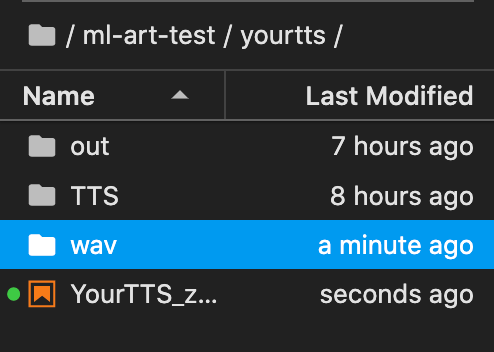

In [ ]:
from os import listdir
from os.path import isfile, join

mypath = "wav"
reference_files = [join(mypath, f) for f in listdir(mypath) if isfile(join(mypath, f))]
print(reference_files)

normalization does not work yet on OOD

In [ ]:
# for sample in reference_files:
#     !ffmpeg-normalize $sample -nt rms -t=-27 -o $sample -ar 16000 -f

### Compute embedding

In [ ]:
reference_emb = SE_speaker_manager.compute_d_vector_from_clip(reference_files)

### Define inference variables

In [ ]:
model.length_scale = 1  # scaler for the duration predictor. The larger it is, the slower the speech.
model.inference_noise_scale = 0.3 # defines the noise variance applied to the random z vector at inference.
model.inference_noise_scale_dp = 0.3 # defines the noise variance applied to the duration predictor z vector at inference.
text = "It took me quite a long time to develop a voice and now that I have it I am not going to be silent."

### Chose language id

In [ ]:
model.language_manager.language_id_mapping

In [ ]:
language_id = 0

### Sythesis

In [ ]:
print(" > text: {}".format(text))
wav, alignment, _, _ = synthesis(
                    model,
                    text,
                    C,
                    "cuda" in str(next(model.parameters()).device),
                    ap,
                    speaker_id=None,
                    d_vector=reference_emb,
                    style_wav=None,
                    language_id=language_id,
                    enable_eos_bos_chars=C.enable_eos_bos_chars,
                    use_griffin_lim=True,
                    do_trim_silence=False,
                ).values()
print("Generated Audio")
IPython.display.display(Audio(wav, rate=ap.sample_rate))
file_name = text.replace(" ", "_")
file_name = file_name.translate(str.maketrans('', '', string.punctuation.replace('_', ''))) + '.wav'
out_path = os.path.join(OUT_PATH, file_name)
print(" > Saving output to {}".format(out_path))
ap.save_wav(wav, out_path)